# **Estimation of Obesity Levels Based On Eating Habits and Physical Condition**

Week 10 Machine Learning

Raihana Fawaz (1103210102)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [2]:
# Memuat dataset
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [5]:
df.isna().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [6]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [7]:
# Melakukan encoding pada kolom kategorikal menggunakan LabelEncoder
label_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
label_encoder = LabelEncoder()

for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [8]:
# Menentukan fitur (X) dan target (y)
X = df.drop(['NObeyesdad'], axis=1)  # Menghapus kolom target
y = df['NObeyesdad']  # Kolom target

In [9]:
# Split data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Standardisasi fitur numerik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Konversi data ke tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [12]:
# Menyusun model MLP untuk regresi
class MLPRegression(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons, activation):
        super(MLPRegression, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.activation = activation

        # Membuat layer input ke layer tersembunyi
        layers = []
        layers.append(nn.Linear(self.input_size, self.neurons))

        # Menambahkan hidden layers
        for _ in range(self.hidden_layers - 1):
            layers.append(self.activation())
            layers.append(nn.Linear(self.neurons, self.neurons))

        layers.append(nn.Linear(self.neurons, 1))  # Layer output

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()


In [13]:
# Setup perangkat (GPU jika tersedia)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter yang akan diuji
hidden_layers = [1, 2, 3]
neurons = [4, 8, 16, 32, 64]
activations = [nn.Sigmoid, nn.ReLU, nn.Softmax, nn.Tanh]  # Changed nn.RelU to nn.ReLU
epochs_list = [1,10,25,50,100,250]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16,32,64,128,256,512]

# Menyimpan hasil
results = []

# Melakukan eksperimen dengan kombinasi hyperparameter
for layers in hidden_layers:
    for neuron in neurons:
        for activation in activations:
            for epochs in epochs_list:
                for lr in learning_rates:
                    for batch_size in batch_sizes:
                        # Membuat dan memindahkan model ke perangkat (GPU atau CPU)
                        model = MLPRegression(input_size=X_train_tensor.shape[1],
                                              hidden_layers=layers,
                                              neurons=neuron,
                                              activation=activation).to(device)

                        # Mendefinisikan loss function dan optimizer
                        criterion = nn.MSELoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                        # Training loop
                        for epoch in range(epochs):
                            model.train()
                            optimizer.zero_grad()
                            outputs = model(X_train_tensor.to(device))
                            loss = criterion(outputs, y_train_tensor.to(device))
                            loss.backward()
                            optimizer.step()

                        # Evaluasi model setelah pelatihan
                        model.eval()
                        with torch.no_grad():
                            y_pred = model(X_test_tensor.to(device)).cpu().numpy()
                            mae = mean_absolute_error(y_test, y_pred)
                            mse = mean_squared_error(y_test, y_pred)
                            r2 = r2_score(y_test, y_pred)
                            accuracy = (1 - mae / max(y_test)) * 100  # Estimasi akurasi

                        # Menyimpan hasil
                        results.append({
                            'layers': layers,
                            'neurons': neuron,
                            'activation': activation.__name__,
                            'epochs': epochs,
                            'lr': lr,
                            'batch_size': batch_size,
                            'mae': mae,
                            'mse': mse,
                            'r2': r2,
                            'accuracy': accuracy
                        })
                        print(f"Layers: {layers}, Neurons: {neuron}, Activation: {activation.__name__}, Epochs: {epochs}, LR: {lr}, Batch Size: {batch_size}, Accuracy:{accuracy}")

Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-692.6013287641197
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-14096.760905418367
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-25398.07284562206
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-586.6791184066881
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-15040.365094270546
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-14440.062943737368
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:8.78734669176211
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-2.8692050934589375
Layers: 1, Neurons: 4, Activation: Sigmoid, Epochs: 1, LR: 1, Batch Size: 64, Accuracy:43.960627666883724
Layers: 1, Neurons: 4, Activation: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:42.86557700429214
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:49.00913046360298
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:52.676739918847446
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:53.93676372660343
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-2149.453717315169
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-4698.058945555871
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-3738.2220392249715
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-4803.086883088
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-3535.5211899729575
Layers: 2, Neur

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:58.55534658176491
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:70.72169648746133
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:58.42388573361721
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:69.63395552901981
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:76.05602367596893
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:68.32871481224343
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:69.75559996656774
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:69.46120170085237
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:75.15813350865369


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:74.13732845826446
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:67.90582979636646
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:62.92485830068024
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:62.471800911041385
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:54.32150493734835
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:56.43269698200872
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:57.20575998931348
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:53.68730077671198
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:58.87543153490393
Layers: 2, Neu

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:57.1139344914726
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:54.79918928116771
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:56.34400256277541
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:49.895690606101184
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:55.56106781447563
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:59.92697004589911
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:63.44691361377708
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:47.36105947277506
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:51.43767613785486


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-841.7540795226282
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-970.2376273225104
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-1269.065518149999
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-2015.364219599394
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-653.5390673236079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-987.256873734266
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:70.64092638362948
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:63.68905462741476
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:74.6506657724403
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:73.43318414462657


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:71.29499154169791
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:75.85765499125512
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:77.55815427401012
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:78.02157382546118
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:78.24661810394345


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:77.62031246349508
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:78.72962020249513
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:79.18668452025024
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:69.07739518100206
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:69.11042576187516


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:64.68884326323831
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:59.72289001500164
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:70.01793474264272
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:67.17648799725646
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:58.18266954311149


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:48.45628926810831
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:45.30828036044976
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:54.739947823721
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:48.76296912254641
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:57.160637365071395


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:35.966090051276744
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:45.49292691163514
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:54.40449957729232
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:46.72219476026282
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:59.491290186126


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:47.51617124787083
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-297.8923603504826
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-253.2797131790149


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-473.39900004008894
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-354.6188760311046
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-180.56005510971994


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-291.19337320891395
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:76.45758584881506
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:77.7835877417015


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:77.49927877158608
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:79.18029376331326
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:78.6391591161513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:78.79729270935059
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:80.49656891090086
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:80.2768240689386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:79.9899471214759
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:80.42473845166236
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:80.99964778427066


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:79.2051688365057
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:75.20115102154708
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:74.4965379495523


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:74.17509358543595
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:73.76641202292356
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:74.60548518866982


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:73.05530024100891
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:53.14353142371087
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:58.96232765288312


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:56.578498337802394
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:47.72208664269782
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:55.574562564386554


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:55.018056522529356
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:40.359889502784604
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:53.02065111009786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:45.065326592976696
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:50.90648645404477
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:53.932245968715506


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:53.55878147121204
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:72.07008644386575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:74.49906892528489
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:71.16452586096604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-79.5451976634838
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-1453.9610944647222


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-2130.6947664541935
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:76.30802201322912


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:78.80835660899879
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:80.15422476286773


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:78.2721073914927
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:78.70893121423262


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:80.77417465530107
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:86.88300082047593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:88.20266365605701
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:87.9877805686354


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:82.23040126222998
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:86.82807041398178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:90.51278119391584


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:79.12838461128533


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:78.49750112510272


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:77.33983300726088


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:78.86424351386708


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:78.71064481723957


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:77.58462887471637


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:51.55339681956597


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:61.211354303679386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:47.757415082437774


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:49.89103913964767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:59.00579310125775


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:58.29248216863314


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:54.544624959252964


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:51.25679706676127
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:43.64110497248465


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:43.91036135672207
Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:55.68565449921796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:57.24327350996723


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:72.96857833862305


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:74.87319345263819


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:74.93307464605621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:69.5151410204299


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:73.52920995160667


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:74.96686920206596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:87.23979968551203


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:80.56038467432215


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:79.60481128418323


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:87.28490447885319


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:77.03015687805728


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:83.622476667565


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:90.76642379035529


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:94.23501973221676


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:94.0956132302987


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:94.04747064560769


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:90.36037300025693


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:94.1953805791195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:84.69652447928773


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:84.1404606428928


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:82.25016010216224


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:84.69801644484201


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:83.29969221202053


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:84.35422662936205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:68.29220132155152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:72.61618294990184


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:66.26424673648215


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:73.31162143448753


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:67.01748882625121


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:72.40722416140508


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:53.837205490891485


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:55.302266688493404


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:49.078971370056536


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:52.6373279609015


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:50.2720904485906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:51.951347023595076
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-5464.91761158732
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-470.71784900998955
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-10872.977041089694
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-5827.082448422768
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-13687.902603570265
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-574.7663715488804
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:20.002480082572028
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:16.691519666413235
Layers: 2, Neurons: 4, Activation: Tanh, Epochs: 1,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:48.640146515705716
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:49.15491818876788
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:47.083050865677045
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:49.5327110312016
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:46.523997839320074
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:54.16910067887595
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-4637.286628560818
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-3133.1098347597
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-6211.4672348948325
Layers: 2, N

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-12456.025864741669
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:68.11872235990305
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:59.224176035799125
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:13.785808057274007
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:-52.87832687744671
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-10.090520947443583
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:39.48869502290766
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:76.21201243900332
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:76.39599397860708
Layers: 2, Neurons: 8, Activat

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:77.22815903178156
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:75.16412332924075
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:75.67141144833667
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:62.41706748756486
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:60.57828311097255
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:58.936329486569235
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:55.364952126622114
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:54.47168076943703
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:59.378293642761015
Layers: 2, Ne

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:54.49848466789844
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:54.92676342033889
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:53.898154409313136
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:56.91807615512745
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:53.0458776506326
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:48.00210775729706
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:55.48916366846661
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:44.79008211546568
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:52.3631970269695
L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-3077.4784799069284
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-3501.941315070018
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-68.87211510287766
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-2252.202820759105
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-1598.4189904515813


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-2991.1157083473777
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:70.56342131796552
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:66.65269097913618
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:73.8141251559141


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:71.1960739653537
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:59.16869626259409
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:68.73464272471278
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:81.13620683398183


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:79.45844373358246
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:79.9528808481962
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:79.83178911925866
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:80.73975503843914


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:81.32989893662263
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:71.22073198416929
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:71.20861296488414
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:69.403405932576


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:71.94949974217127
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:69.14515115314812
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:72.3088348729109
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:54.23444007634177


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:48.41705077423929
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:50.65448782454452
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:55.41044928198071
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:53.71045256055558


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:49.27125093479435
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:49.77069516131218
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:52.72685391483483
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:50.946998464015515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:53.91999439896327
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:45.982888627465634
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:47.32242897270326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-709.3646432021361
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-1437.8830041727558


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-646.3918621282676
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-3266.5174419622517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-317.03717898345536
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-553.4012933525164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:72.70018590351462
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:73.92431444028308


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:75.12003089425318
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:75.90683007259084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:73.28086545657135
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:76.97541946449836
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:82.4323012966918


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:83.71534185253606
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:82.69839819911148
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:80.84360516921473


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:81.47605859371411
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:82.47481851806971
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:75.0866403534621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:74.6085229682772
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:73.8216096815676
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:73.2754251541727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:73.41045224826293
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:73.3948204252455
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:50.81700578396531


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:57.19947297451908
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:60.07775368419945
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:57.092682293919324


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:53.11467177590532
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:48.47320986484524
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:51.21227655826803


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:49.363910949328826
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:54.48509611430086
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:50.7355352474701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:48.27091016397878
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:56.72957267673866


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:13.060058130815888
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:59.958953797300566


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:4.875740430033792
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:63.06686070699969


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:38.489953319889246
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-280.6358594045196


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:78.70373711800181


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:76.47817962464617


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:77.39685297575967


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:78.23769930218786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:75.8470813903027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:78.4530535469476
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:84.20224050845191


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:89.67603376359804
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:87.70441599043454


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:90.37496470695785
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:92.70544611534046


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:90.90082510613004
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:79.42924364473615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:80.37965283079632
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:80.48108579771457


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:80.1752518560118
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:79.5962237496842


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:79.45052217530679
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:64.32502932488401


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:57.65267304894115
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:58.75556027212887


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:57.64405460245878
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:58.12134159254783


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:62.09684450669586
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:52.55826786850337


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:49.405769233784866
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:50.84993968841785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:45.17697006393549
Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:48.949058451656754


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:55.11840095052201


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:66.82079187803515


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:75.31914947726203


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:71.8098600611525


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:71.7547700008696


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:76.8648861617531


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:73.6673745891069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:79.28166693829476


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:77.21821806203482


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:78.92385169076958


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:80.56061929656916


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:77.86748798180979


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:76.98180423983445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:94.23475743302969


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:92.24635629883143


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:93.28881592450881


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:92.6009295633029


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:93.31903302876192


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:91.90306406588513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:87.24129952085215


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:85.92729137093416


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:87.55481889026666


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:86.77168022547654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:85.28073980605818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:87.11063364789278


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:69.47824774152937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:74.0130941871586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:71.60496971004116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:71.80576797918225


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:73.12466027794906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:73.5166563303852


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:48.887572478623355


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:48.75256146052581


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:47.51534737159269


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:49.43214816498512


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:53.80388840422374


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:53.62087884188356
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-4667.014033029735
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-9967.380896734385
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-4936.199345524805
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-5407.344712489604
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-9988.591685794863
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-9698.292819339522
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:55.505742854824014
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:43.56281465437583
Layers: 2, Neurons: 8, Activation: Tanh, Epochs: 1, LR:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:50.941051148212836
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:49.65953596370769
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:52.375471983266394
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-12795.257850929542
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-5494.090338331964
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-15437.030302773695
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-10225.045537084365


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-2142.53710122255
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-13938.8670362949
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:2.053496760585538
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:18.770226458097838
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:19.940559059921636
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:56.03271717157205
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-0.8372437023947521
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-76.75455706245415
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:76.49703632432518
Layers: 2, Neurons: 16,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:76.38152303237253
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:77.08868549225178
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:77.12996722066187
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:76.62759237725308
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:58.11824251386102
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:58.14021813343415
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:62.15230728153922
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:64.35933963251077
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:64.75788774313752
Layers: 2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:53.57373767922111
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:54.22410387765994
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:55.01242458256706
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:50.51968420148953
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:51.58142718193661
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:54.84914153908256
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:50.96186735132273
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:50.08921326586493
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:51.90715875

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-5632.173294416087
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-2641.1241821457406
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-7036.076622745763


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-6436.796510905333
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-5932.27373127678
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-3202.810435374014
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:-30.033741653012513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:5.813182386664362
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:67.34809892867098
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:61.60455473395574
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:43.19823962482906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:55.57526822537302
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:79.09026832398324
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:80.3273079078718
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:78.99683178340102
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:82.02552499617997


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:82.19380327526089
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:79.30124995509314
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:73.2194522124186
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:72.77616723679105
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:72.85366006682857


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:72.4685852972892
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:72.7347658035603
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:73.25432735507746
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:51.51185435312671
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:57.921940083575116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:51.527288530485734
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:52.07043810167047
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:57.18272703430425
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:57.79329534822604
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:50.06244049515425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:44.99303054584115
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:48.28676987377746
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:56.20719642973584
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:51.370331187056586
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:51.1545727103567


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-1160.9692853111467
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-1154.8156332462393


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-628.0084766300764
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-3950.050822348929


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-1034.1167334217646
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-2078.8922020541672


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:73.72166618199871
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:74.19566236395269


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:73.96180123396047
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:76.40039417290895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:73.33859875034968
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:65.21704022202368


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:84.65282324264142
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:86.13833897432255
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:86.37849843530226


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:85.98837662250438
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:84.89960933924661
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:86.53640842653805


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:76.83100288923187
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:78.17904683104456


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:78.36473486008279
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:76.35468833083895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:77.70515875237678
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:76.57011659996448


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:59.71997333052028
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:50.14649723385665


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:57.856370354844785
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:57.123459228575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:53.78293323853853
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:54.513884442612536


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:51.23079128191315
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:51.636279065534765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:50.9893957296514
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:54.2400901263816


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:54.6003351497359
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:52.77071992365438


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:7.494483208261771


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:11.781223032585364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-1127.9951836576229


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-12476.768093244404
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:8.707405132416957


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-0.5343546164702895


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:75.82035326318913


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:76.18228721750168


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:75.7353709615808


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:78.84474598205962


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:78.95369832209474


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:78.54163836455889
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:88.3564809371018


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:89.9251711941592
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:89.3383787996286


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:90.34222355383977
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:90.60071162039883


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:90.16687648269584
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:81.67174159893376


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:81.68917912505479
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:81.65142788684584


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:83.0730149890843
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:81.4762809568498


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:82.27673289200939
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:64.76499762612124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:59.86647499744304
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:65.4065097054691


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:62.56717272261356
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:64.78612755958821


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:62.1184436987478
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:55.10770189917116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:49.82621075102577
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:48.602944926026304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:51.9361128488965
Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:57.09481313178819


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:53.384415409032336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:66.81936067140788


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:-629.9418671099194


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:75.86148083914537


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:74.10018167879


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:-546.7759854592517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:75.90898013284021


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:80.34277093795644


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:79.54395343883476


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:78.89308151623882


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:74.88218097822042


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:81.8038764762728


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:78.90494143145585


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:91.69369033582572


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:92.32398225178015


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:92.61903897738063


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:92.90656165474508


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:92.04991304259116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:92.58750330824097


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:87.33076079241444


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:89.05073084095692


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:88.17725955318568


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:88.94871905786583


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:88.6837112864845


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:88.62667504002299


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:74.59645289149783


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:74.95394353325486


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:74.63046251271446


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:74.66972869996296


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:74.59900628120717


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:74.59333415478586


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:53.67931970479547


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:50.22728884808421


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:50.18859622079712


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:52.305245397420165


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:55.48422956227128


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:54.5539983110084
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-905.1418176685571
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-22640.388519018066
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-23645.14364989561
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-15979.556613272809
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-11455.236733814598
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-17942.08900438133
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:65.93956967523664
Layers: 2, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-574.6697054593182
Layers: 2, Neurons: 16, Activation: Tanh, Ep

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 512, Accuracy:51.22799037847818
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:50.78717283258718
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:53.27114724532838
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:50.35854893302805
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:50.30851268346757
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:52.38220473858575
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:47.89389368584064
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-27317.870413176744
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-20402.450597596224


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-24346.753238711044
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-26665.24992387439
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-25069.672143393564


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-20475.20103965621
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:-75.42322833675206
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:-149.62731600747134
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:-304.29327809218813
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:25.83527705911767
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-205.18944983974606
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-436.1497221639346
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:71.9333031076066


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:74.38581988415068
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:74.65997295082789
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:74.49153841622145
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:74.68012044803658
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:74.87621520615826
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:64.63216316333617
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:67.21037383432741
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:64.79186833233604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:65.87215886987788
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:59.11986160174987
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:64.94582731766998
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:53.15651857067367
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:51.856141265149994
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:54.0299286157292
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:53.5396737973459
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:52.30075244236241
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:54.4213305797701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:51.10313041895993
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:52.64872677559642
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:50.90240245263722
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:53.146341502654735
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:51.847695417473226
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:50.49274347405483
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-8742.958333682038
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-19310.14446862764


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-16905.601834311456
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-5534.444771985354


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-8089.347891059798
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-7953.135495978701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:-51.23652674204913
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:-31.422469393299558


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:17.242105228868976
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:36.01855240627195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:58.54935656390479
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:46.59065317224573


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:84.30122967495328
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:84.07734069207035
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:84.15675381326224
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:84.44692604684096


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:84.43509323846834
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:84.62871553462918
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:70.83616363804954
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:70.73724120503057


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:70.63365144181006
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:70.88657032325571
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:70.43782415307346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:71.18411267057378
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:54.1584154269515
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:56.87102238853867
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:54.77093276754903
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:57.82442741782954
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:54.63831925528364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:56.93743661738833
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:52.01393536851984
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:50.82942070035812
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:51.66482314015346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:52.16350876751896
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:52.28193718118048
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:51.264936763755074


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-26711.443858526185
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-1581.7401717646653


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-3862.7177822392605
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-13519.91923206711


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-2194.9802739118572
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-5465.344220846069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:-15.920831290072957


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:72.86413169639894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:72.37347303364952


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:31.129519284429097


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:36.891284977196705


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:68.90630719227713
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:88.46616945556057


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:88.69162057684198
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:89.37883368620636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:89.11727294032268
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:88.35394390461668


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:88.78410767743303
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:77.40268148569915


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:77.88590066915802
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:77.93756827676832


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:78.53520580687045
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:78.19984208137807


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:78.00496464361818
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:59.01882612770988


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:56.818322557882595
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:55.12146378498175
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:59.73898920137361


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:58.039567135186346
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:59.60884126647426


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:49.331242576464604
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:51.29748088938102


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:51.98240413266646
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:49.186942227906925
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:54.33286509533113
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:49.95586302005183


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:-1803.2066089699267


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:-9675.053944448679


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-8826.513533595982


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-18325.789816084576


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-320.2058799629422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-304.4275427353109


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:73.61428951822555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:74.43305581831575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:76.92160782990632


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:61.82960020077333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:74.28204048515963


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:77.3768215596535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:90.5745267128268


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:90.7024248823864


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:90.39209603770124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:89.64908487384389


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:91.0007653424738


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:92.05818664755195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:84.81000057172832


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:85.56401168705912


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:83.76053060317622


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:85.13411578698079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:85.55840595124086


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:83.79033462454876


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:66.13118073149306
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:65.77943767779826


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:66.56408479497411
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:68.04202652710268


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:66.05612491415278


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:67.16476344423468
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:52.15399827150564


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:52.93454799809918
Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:54.1377974875195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:54.78217719376697


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:50.4425753794546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:52.22006251615707


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:-3070.4726123734663


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:49.37535489610653


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:73.84560297942706


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:72.38729445365021


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:63.62780487565567


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:75.04030653019417


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:75.94398768329546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:67.18030810074322


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:77.80866124105792


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:75.10303492805355


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:78.90870914720381


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:61.567888878009946


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:91.83127300665545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:90.76146297773289


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:92.17399152552076


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:92.49291310543335


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:91.55944415299886


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:91.27387154914902


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:88.24880717893207


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:88.35302887233436


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:90.53296653525955


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:89.54309673996023


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:89.31646050549192


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:88.50366262597207


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:75.86408837091463


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:75.74110402189153


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:76.31778597737787


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:75.97106489447555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:75.50619393939387


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:75.5857133743235


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:53.87060956294092


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:54.03727971551642


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:54.12154867247017


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:54.46674304333985


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:54.22901603722779


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:54.01463932743027
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-51792.73192756658
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-1791.3829958654933
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-17288.327982145747
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-20476.884440383732
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-18523.103736346868
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-11799.830887015172
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-20.848017628029435
Layers: 2, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-244.32773463269496
Layers: 2, Neurons: 32, Activation: Ta

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 16, Accuracy:52.19170954944441
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 32, Accuracy:51.13633174399299
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 64, Accuracy:53.22793819086584
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 128, Accuracy:50.809009318292084
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 256, Accuracy:52.921774810498576
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 512, Accuracy:50.644683236237164
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:52.38443094344591
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:52.58860511601065
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:51.91181561222682
L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-63322.273344576504
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-58611.86336580462


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-60988.012696364625
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-41991.27991347918


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-44045.99720479185
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-57668.19012448767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:-172.27168735131397
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:-187.47131939099657
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:-645.4276108196912
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:-149.84760838667177


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-159.09594222257417
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-294.9785844654056
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:76.31123794508412
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:79.80115348847482
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:72.5942824420448
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:79.60232793110576


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:70.98605835221714
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:79.1215501097453
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:70.6404980662491
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:70.87845371124592
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:69.39992676859677
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:70.22292345316039


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:68.88296898656985
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:71.58480879826467
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:54.43180423256353
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:52.96445935348106
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:52.336396457490906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:53.91368865673236
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:54.1705208185435
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:53.390638111049114
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:50.8213775468751
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:50.77837777916281
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:50.64918216540999


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:53.3716175256046
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:52.226160838172554
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:51.26763518996553


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-31702.154541015625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-17415.700441988738


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-17828.77786694971


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-17916.87716460773


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-26573.77706321794


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-15904.402364155172


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:-355.4069179263615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:-117.21038859692779


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:-298.93994352261416


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:-78.83512945603535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:-120.84460386241678


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:-91.44822653115877
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:84.01554747417839
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:85.6370188607016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:84.32992025446573
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:83.86094301786359
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:84.87060945319604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:83.14346130364893
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:72.8602915509091
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:71.8089291671771


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:73.42455555267273
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:73.68562289163576
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:73.1683392239143


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:72.37006618433622
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:55.07761151937165
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:55.762602346585986


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:56.397836827405136
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:56.080640409761195
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:56.412491690840085


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:58.53371904110514
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:52.98291101840371
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:51.40507390606677


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:52.751113339330935
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:52.51934448428821
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:49.580136780209486


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:53.09322463646473


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-13410.850081282211


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-23747.017954051542


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-8294.357320847148


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-8391.600118386079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-10698.315792219013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-2183.7257584029994


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:-23.246321685676797


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:-45.14911954002743


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:-110.24149010931063


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:17.544623525993764


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:15.967799238185421


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:63.05837259224967
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:89.79123695874608


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:89.50298593164524
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:89.73876946995445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:89.1274872060551
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:89.51401678218534


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:89.54166846542118
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:77.84872876789929


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:79.28168053839318
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:78.53839022670326


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:78.00117267502678
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:77.99778280763574


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:79.05824776589165
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:61.83251367017357


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:60.18744813494086
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:61.10923639003267


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:60.876513807392186
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:60.52457656655563


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:62.43179532793961
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:50.28213259182031


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:51.820540272427465
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:53.98208530248385


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:52.918059190102596
Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:52.692942475713636


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:53.21968598151836


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:-250.68731751378076


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:-382.865315370432


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-37407.951743364145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-24359.79435096302


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-856.6941991013932


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-765.8866751560365


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:75.93830896231769


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:70.15100444180464


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:75.6459017453746


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:49.61692636834063


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:-62.529062867822184


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:-272.4691225281844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:91.46416546018035


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:90.83354313886475


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:90.88709827033998


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:91.3226547182029


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:90.25440773419548


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:91.5624081654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:86.09426456985744


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:86.35644230219538


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:86.17261990176776


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:86.0859111039492


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:86.30554047159974


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:85.93953751773229


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:71.58333494308147


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:72.20346139489993


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:71.9541195718391


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:72.28712996128885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:72.09630734907351


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:71.45435828877021


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:54.47490844755214


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:54.91024664272184


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:53.298050450517785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:52.73705823501091


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:52.57396901318461


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:54.04866123241736


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:74.38263025125995


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:48.11537752384459


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:-4743.7616019102425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:-3.9697016196705626


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:-156.20618058152797


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:42.76334410863566


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:78.55982376516477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:72.45730869971081


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:66.97683522699384


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:78.14100041128313


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:11.553412727524304


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:68.07100416357072


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:91.95643552322854


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:91.81786891017212


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:91.07495242446497


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:91.8914897950077


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:91.65162203159738


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:92.37149316697162


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:89.14707897449685


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:89.70530663093683


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:89.02218280443768


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:90.56972829556024


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:89.2060744773576


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:89.1834102899799


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:78.65165686917362


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:77.89638732905647


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:77.74013162504697


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:78.298549015894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:78.54623115901124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:78.18644526227429


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:55.40125362745321


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:56.67892053805532


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:55.864062919402514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:56.31421697337014


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:57.28120752988226


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 2, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:56.62423379783841
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-71792.84656365337
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-22413.615435216256
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-31583.24691011175
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-186142.11584441393
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-94359.64695278165
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-10588.93377046307
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-215.85757707027676
Layers: 2, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-646.8041118155135
Layers: 2, Neurons: 64, Activation: Tanh, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 256, Accuracy:46.54286979125934
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 512, Accuracy:52.04970846092072
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:43.974266643360714
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:42.96861693462676
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:44.70360678091493
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:42.855938869822765
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:46.340871752012994
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:57.451259314872985
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-4696.97822949565
Layers

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:38.799425896177894
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:64.81589526994853
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:71.60751657095173
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:66.9529697104079
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:70.76732995850162
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:69.91241617029911
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:72.5613465264052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:60.64043738552676
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:52.128176473321844
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:56.09969993549788
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:64.5221098987393
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:52.30156446978085
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:59.86921479609934
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:52.08623662240175


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:49.3064116977208
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:48.05597582548692
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:54.8572512946794
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:54.2778775976623
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:57.10140843035387
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:51.32913333154669
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:51.329001758344496


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:46.480797067977385
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:55.662884914893816
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:51.062361348106265
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:53.98112594482465
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-755.8201052618365


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:40.842968014115144
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-1621.7240435011843
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-347.19571052713604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-1005.0864118210812
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-3338.628620120651
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:71.25900486870202


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:72.52229325314785
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:69.8662834622148
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:69.31740218396259
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:71.94763494345784


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:68.37888335129519
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:75.34977014464971
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:74.26534503158196
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:72.23013615965186


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:77.14764385170783
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:74.49832447313528
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:77.3268442204658
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:65.93599380988412


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:64.84428935862603
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:65.32445252176531
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:59.521878061565104


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:65.77405059215495
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:59.633438980795425
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:53.59826066580413


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:54.53682013554682
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:50.9496330632186
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:49.45253292707781


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:57.286618169693604
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:48.01507996552286
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:48.19599236497455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:54.5963498605951
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:48.36904400911174
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:52.73248572063971


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:46.50557183134359
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:45.33348913804295
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-1010.4701576503456
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-258.5678317022662


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-205.9451840448041
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-85.50560254577204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-771.5839602423052
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-897.2825584682167


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:71.80187261602464
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:71.64145127537684


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:71.03548294169588
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:78.18893783669287


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:72.56177970046036
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:72.306188605168


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:80.13544473195283
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:81.00084797827816


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:80.14727975788597
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:81.02811240511113


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:79.63474329951431
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:81.2415326881634


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:72.07356392632703
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:71.82852062679257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:71.96139802699768
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:72.2465954773815


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:72.71984198414687
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:72.07653564764254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:50.99161268337398
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:61.16233316813049


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:47.559108256330816
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:56.30563471475109


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:57.98002975582606
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:46.52288257371168


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:57.447922492797574
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:54.73867491052036


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:45.17377457861077
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:49.99429981559632


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:55.811302608115355
Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:51.14763871076025


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:65.05759857694777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:55.98641688237518


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-29.292430268957247


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:52.25669632895524


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-28.303549475703683


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:63.79514383086076


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:72.52445191826004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:77.7494046892868


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:48.973425924543136


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:72.34114732584491


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:72.44589539190463


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:77.48254852279891


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:88.9641204483402


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:82.50018137942345


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:86.8540851500581


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:79.67241252379871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:87.48774937257888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:85.54530175912089


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:75.11915323582102


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:74.62910962349041


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:74.55526758499084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:74.81409258688407


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:74.97243797619386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:73.53764631505835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:58.491817403253


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:59.37215068661574


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:50.328687776887016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:61.24322267852496


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:53.94415793583749


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:59.85003240565037


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:42.41240272567064


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:55.04567658013486


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:54.239329197234866


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:50.49004891932809


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:58.734875745995005


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:44.86540279771701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:72.45981939389445


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:72.4608414562036


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:72.46056038906859


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:72.43389733857862


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:72.46293668393736


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:72.45905284716258


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:72.46144032083785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:72.46145357570843


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:72.40108535269098


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:72.46144032083785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:72.45486169654238


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:72.46142910445555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:94.83090080643753


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:94.32263047418978


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:94.06603445938198


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:92.47154588183612


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:90.24670703660982


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:94.4689989066481


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:84.31247842708754


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:82.52039163882006


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:84.2512389709564


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:85.3954008061929


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:84.16484521189668


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:84.03084397409918


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:61.658101712652226


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:68.68591832776441


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:65.68685180564111


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:65.3827551690681


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:67.80419144882191


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:69.05458422041578


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:56.91701960643509


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:52.782358119955575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:49.68046812477124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:57.53325174604464


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:47.032966599208905


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 4, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:44.52827596072609
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-204.1784448826567
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-487.5716518284864
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-6171.710618412147
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-8340.892794754112
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-6415.297498169427
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-3218.730743744882
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-4.8479787142282404
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:42.283775942169655
Layers: 3, Neurons: 4, Activation: Tanh, Epochs: 1, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:49.875712417612114
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:47.68886036636606
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:55.20762608241998
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:49.9332826279274
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-3613.31738411112
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-9011.880471520391
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-918.5082537062625
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-3971.4459520705204
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-8871.996074703568
Layers: 3, Neur

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:72.73330150202939
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:71.78450301465695
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:71.87455444471212
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:71.09965943651373
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:71.77973137397856
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:59.04643150227007
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:65.72565184605226
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:57.64224354773641
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:60.219061640043535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:56.95173368856041
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:60.672765796441944
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:55.86743845396667
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:55.91053160228909
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:46.30147848686333
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:60.28223252371598
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:51.59569442495293
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:51.24112099190401
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:49.538307924666114


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:48.07197639353168
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:51.011290719146984
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:51.308261929556934
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:51.880567835260784
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:52.582023732828006
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-4605.699179358517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-1958.8777961460412
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-3664.9876695998173
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-4832.695537594193
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-5482.895893069869


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-6939.53194043315
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:72.25380559151712
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:71.73283416704459
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:67.80124781543199


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:48.057066445467136
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:70.06599889955152
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:55.504066123090645
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:79.18465695717468


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:77.7153806671371
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:78.06038832082065
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:80.42441025270638
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:79.7767482703835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:79.03889216617678
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:72.4170662268961
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:67.94312100789976
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:66.87889303439616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:69.32601805650127
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:66.37578125165334
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:71.52466680047266
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:56.86146913197587
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:55.9934052627701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:54.11029402210639
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:52.0311069991102
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:52.3260096374274
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:50.96454632925742
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:55.572573022169806


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:53.642683480319484
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:48.02521700120236
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:48.216239060587164
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:51.677767267792696
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:52.37840209053528


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:19.771458916630312
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-563.7971458705605


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-300.42501363912095
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-1140.5711911248823


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-758.7980053949018
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-585.9783591953575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:64.43092729089015
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:79.85229383687319


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:72.13998400761068
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:72.18307418274634


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:71.68322359134682
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:71.7720567193719


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:82.1070820727247
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:80.99317647182069
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:82.0630807943284


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:81.18795729040443
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:84.23562115388559


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:81.67032902051935
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:71.37383175610181


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:71.9721750258648
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:72.76969253782028


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:71.45406042524358
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:71.67346685114951


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:71.45396181689745
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:57.840287690091266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:49.158960737587435
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:52.673283357311185


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:57.68673901744863
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:60.13980323494279


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:55.23312250585233
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:53.89897936530899


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:50.87887539584821
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:54.04100623172601


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:55.432918590293134
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:51.74121868255761


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:56.011003286374475


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:-609.9466540289263


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:-102.60358431660536


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-12.41714734557673
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:60.61794320084712


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:66.95867798476824
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:69.69168199339282


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:80.07761147944734


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:72.46885203864275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:72.30104135659099


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:72.3691372349095


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:79.64383534693737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:79.24519293509289
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:91.13199331799862


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:89.39203469418841
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:88.9059896082555


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:88.42143366381914
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:88.9782903558913


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:92.98458891980191
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:75.3454232704367


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:75.87157964142783
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:75.49812083548689


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:75.66263602416848
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:76.80934344904924


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:78.25051379823798
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:60.9594626864455


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:58.31565733872783
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:64.46781559099448


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:56.03953625763185
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:61.964558075505785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:59.39756311752178
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:50.22627147776204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:55.900807959343894
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:54.95553681872038


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:54.33844106288008
Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:49.986059086836164


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:56.357550508305266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:-817.8995551792442


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:72.46416315870835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:72.45947444786512


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:72.51358663500342


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:72.4595511025383


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:72.4621318098689


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:80.3739052480182


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:71.65553535975462


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:72.46151577308481


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:84.6603349966736


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:72.46158721411294


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:74.2312759466299


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:94.61356696531095


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:94.38352659403385


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:94.1518062054876


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:93.79069667054124


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:93.39020549311611


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:93.48878223446057


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:87.97363149217962


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:87.80535538192807


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:89.8918085029221


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:88.77447004201753


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:88.92002184739538


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:89.58559451115423


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:72.17559336300813


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:70.71123202547865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:71.61412895712165


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:70.48216516150556


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:72.01085695607912


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:67.8726771903658


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:53.54969499616571


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:55.99352425952142


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:56.30891891071607


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:48.27497425137588


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:54.31589788637638


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 8, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:49.98387641782034
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-9253.978960564797
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-9819.512760291615
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-8250.595482960754
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-6536.156470536998
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-3773.001826701904
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-12505.154097897504
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:30.95017108887176
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:60.04314395834649
Layers: 3, Neurons: 8, Activation: Tanh, Epochs: 1, LR:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 128, Accuracy:48.444580519828776
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 256, Accuracy:51.96988096415198
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 512, Accuracy:52.42653373156221
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:54.225827200474754
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:47.00914997346201
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 64, Accuracy:47.74565662252236
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 128, Accuracy:55.27272304157462
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 256, Accuracy:50.98310723413484
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 512, Accuracy:50.15533301125

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-9010.819477054245
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-23263.109312666224
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-14389.975430103059
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-13051.438416825962
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:71.32061817591541


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:28.20537259392705
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:-54.1762738832815
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:-5.616396895725018
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-74.44853919805554
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-5.560858931665447
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:72.03539663454602


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:72.2348530335723
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:72.46632372139945
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:71.35593131172836
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:70.98116003875191
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:71.62127941024876
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:64.92396440911801
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:61.39005134667441
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:59.02952623470643


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:59.65261181054669
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:64.55676688088312
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:59.00179505160325
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:51.44628221484693
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:52.348795814705326
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:47.927162821505185


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:53.99527283072754
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:53.73799169011902
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:51.236256465632856
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:54.65006787503113
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:55.00604400632887
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:51.92961954541793
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:44.87409836152485


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:52.123592976463115
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:48.17225783828491
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-11263.839700036016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-11039.096090979609
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-1507.333904293412


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-7792.023743974401
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-15723.826112138462
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-1899.431461307174


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:70.6250925342148
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:68.64354232806123
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:44.776864010485454


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:49.77551329502259
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:-12.933671972336413
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:7.06402257824621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:78.64075327032283
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:78.66052787683441
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:79.39727463479865
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:77.8728839517861


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:76.92740390956449
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:78.14683576471886
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:72.52734833763188
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:71.80163468593119


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:72.5140385687868
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:71.67801082932732
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:72.41770952493773
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:72.01201152951818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:56.125722395753755
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:52.67789132358804
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:54.08936927551542
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:55.167625957206056


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:54.3132925756904
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:50.41471576249157
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:53.93991988765807
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:49.418557033095425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:51.36360094447343
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:54.97993390399514
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:53.579350978934556
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:50.814471763417046


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-2725.0402031215367
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-672.2638664516152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-1466.2822939825396
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-2237.9358710972133


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-459.1438077020307
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-3368.629179609583


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:70.51952507103213
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:59.94057334061209


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:73.15129035095984
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:72.48257917151666


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:72.39479971645947
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:72.17529718099944


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:87.58765506030444
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:84.40253817959974


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:87.16372523935317
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:85.78830816973093


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:83.46724700068188
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:86.3573863609181


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:72.68064253155504
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:72.93813009728025


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:72.88526804828568
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:72.56167255300909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:72.72022455296619
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:71.70711828086019


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:58.03078669699466
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:54.8330392920426


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:53.89524042794234
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:57.856091033811175


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:54.11453965942723
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:53.743229760040535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:53.08954623433151
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:51.90627444065796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:55.52082875871207
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:52.925102203391596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:52.062755706004495
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:54.281360087101625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:42.87790677226181


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:33.848631598049494


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-133.64078778747123


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-43.426217424108614


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-338.57872266295954


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-286.52199684305396


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:77.79037688452959


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:78.34923736827405


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:72.09452811519964


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:72.26682312381465


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:77.20839015323408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:72.42005310066108
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:89.61532788543461


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:88.9541683138779
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:90.90542863024042


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:90.01211935464936
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:89.77728175121185


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:90.22234024331736
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:78.75114651154684


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:78.72104492123621
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:79.2368840663991


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:78.5237140877215
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:79.86649553826514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:78.98096275010195
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:64.66601081867684


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:61.165578645735486
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:63.507761849109535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:58.625637362377205
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:65.84813871000395


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:63.125710317335134


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:54.670220067455986
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:52.00564680977704
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:54.110704648320926


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:53.317058069955834
Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:51.42735309481996


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:50.19486167059346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:72.2254635030778


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:72.44386883398226


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:72.45381477782819


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:-38.63431037740506


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:72.45864402223891


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:72.40608491890069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:75.64746182062572


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:72.46375704863767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:72.46140852230003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:72.46165671998634


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:72.45990217342633


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:72.4624227688386


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:93.26369268181193


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:92.74356951151803


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:93.39956555477364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:91.46008993857859


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:93.4486518033477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:92.34051477542724


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:91.3788847554801


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:89.53782031686876


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:89.15972981963034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:88.19106380543998


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:88.13145196181263


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:89.77610868048818


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:72.65494680479814


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:72.53519436616048


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:72.47534083794007


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:72.79029419517968


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:72.62109672112011


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:72.51363856478692


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:50.399009626244265


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:52.98807494624145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:53.95523438052552


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:54.671944927943805


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:55.049832578575256


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 16, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:52.81559714681996
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-8904.53011563108
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-49048.33149289972
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-736.5168384344584
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-29258.803044612996
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-333.4583091585537
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-8397.79181935075
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-393.8420547637722
Layers: 3, Neurons: 16, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:71.28969693014808
Layers: 3, Neurons: 16, Activation: Tanh, Epoch

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 512, Accuracy:49.194933948458605
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 16, Accuracy:49.919724317635946
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 32, Accuracy:51.43754455129563
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 64, Accuracy:52.271857632396014
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 128, Accuracy:53.527748029329715
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 256, Accuracy:52.04305983903701
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 512, Accuracy:52.833379614860455
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 16, Accuracy:50.52774016216244
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 1, LR: 0.0001, Batch Size: 32, Accuracy:49.47453518321046


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 16, Accuracy:-19179.517616410252
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-45533.154768226086


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-36538.69707785412
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-32713.78888069315


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-29863.489947908973
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-25004.44435498393


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:-129.2608511363361
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:64.61144659442166
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:-195.49803279158255
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:-71.90299913392843
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-148.82970077959547


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-93.21497157392209
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:69.75355006466708
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:71.13925820734673
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:70.37739167540349
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:72.29177603297012


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:71.76173081822617
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:70.80281283368832
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:60.63967909842989
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:63.79332196721887
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:66.05453217846846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:65.71362758828863
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:67.31257886281625
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:64.1578740637729
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:51.92229620102498


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:55.176531037916064
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:52.69531634371285
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:53.406527600272426
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:50.624387961694154


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:52.848348979103555
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:48.463088052657014
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:52.630028713984785
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:51.949636103956706


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:48.649588732197124
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:52.86768665838137
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:51.45190005418914


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-11673.581971513464


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-1570.916642533972


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-1903.5078900925657


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-10194.611634599401


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-14875.554424312944


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-1392.1798489617963
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:69.985588372834


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:-12.90151035813858
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:-54.72816992595122


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:-24.412343857136175
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:-0.3984911597742613


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:46.89327265166033
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:81.15121723630467
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:77.1049632764971


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:81.95182678852615
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:81.98980080203056
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:79.24520533981052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:81.32463605433021
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:70.0961417903855
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:69.9388703649865


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:70.14027146301089
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:69.94805879908532
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:69.88721274315043


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:70.28675141345806
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:55.686873888011235
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:52.74238353690546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:53.49913383969835
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:53.241600581775785
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:55.51115905820525


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:55.38317213925534
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:50.09569344444713
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:50.51429553722142


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:50.39866903666157
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:51.35358197246131
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:53.68127928146986


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:52.01128897249077


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-2938.8625882196093


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-2047.5053620394804


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-177.48895266377338


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-1439.1522508986452


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-7655.626911136275


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-3541.439034752812


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:35.66808437530782


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:50.062958643697584


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:55.995196785111425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:71.57558164228315


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:35.633021795063904


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:71.77269710528746
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:88.09930197806504


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:87.05421444512992
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:88.65411720870516


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:87.3714326309162
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:88.53407402715878


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:87.18003319698211
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:72.71458600993415


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:72.89639339379386
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:72.85717848814595


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:72.799060605848
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:72.79481543998628


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:72.31582959305123
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:59.7716187636997


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:55.65660045642944
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:58.56523907870359


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:59.359655869204374


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:57.96824628861519
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:57.9117730436032


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:52.63600939366646
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:53.50856454565922


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:55.31543714263667
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:53.50867654215266


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:51.889167161815465
Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:54.54661440518167


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:-345.8806775140424


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:-221.99324546976294


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:47.31539665384496


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-611.0943895705202


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-373.74460477355524


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-636.2213351202349


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:77.22949685310171


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:76.31956193276143


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:72.13364087098033


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:4.026905808324788


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:71.992734720427


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:72.4382677070732


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:90.87518134438399


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:89.3928964756623


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:91.07839069303516


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:90.86769841922559


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:89.44880311488166


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:91.93708979538616


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:81.07686124982752


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:81.56032891513983


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:80.6842456472681


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:82.4988347583159


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:81.543783750752


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:82.23551899265172


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:67.24415313925117


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:65.93888511894444


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:65.99769935164514


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:64.6005068358894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:65.01149067829874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:66.34893150570076


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:54.71161689001618


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:52.180006599436844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:54.12949846486485


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:53.51376833527741


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:51.3759175710339


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:51.36110175788473


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:72.46155689982


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:72.68345568290933


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:72.46567070061434


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:70.75877234727214


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:40.75459511473575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:72.47627779101649


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:-254.613885210667


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:72.46132137457906


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:72.46111156998703


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:72.90016064219253


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:73.67211285775998


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:77.49124411244013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:92.8709892211137


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:93.22135007996744


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:91.76654986878658


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:91.9691443989322


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:91.3851066484425


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:92.16153303923055


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:89.18002073787346


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:89.95044749373992


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:89.6792776380659


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:88.6852058747136


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:89.72037896408257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:89.70402313016173


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:72.59582438931116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:72.60011477767247


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:72.57953745065664


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:72.61587438666042


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:72.57323878500948


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:72.58660556576777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:52.42894257883373


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:55.060210369580176


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:54.64407587211089


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:54.10775889718129


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:55.83522822252871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 32, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:56.00800275379885
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-20682.794589259855
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-30212.12057920776
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-33033.7607405522
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-209994.26526609983
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-22481.928910900988
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-36330.3636399097
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-172.8040519805289
Layers: 3, Neurons: 32, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-2079.036941821412
Layers: 3, Neurons: 32, Activation: Tanh, Ep

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 32, Accuracy:54.41810464511432
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 64, Accuracy:53.513690111226595
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 128, Accuracy:51.80662946028443
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 256, Accuracy:52.135940140643115
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.01, Batch Size: 512, Accuracy:51.37901619029759
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 16, Accuracy:52.06964327854679
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 32, Accuracy:51.62819856858516
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 64, Accuracy:53.0639852063218
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 1, LR: 0.001, Batch Size: 128, Accuracy:51.82158720860854
Layers: 3,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 32, Accuracy:-35914.44602587544


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 64, Accuracy:-89316.12265055532


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 128, Accuracy:-93260.08193043858


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 256, Accuracy:-60363.345137311306


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 10, Batch Size: 512, Accuracy:-112441.28314079123
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 16, Accuracy:-843.0200058235907
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 32, Accuracy:-466.89864369806486
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 64, Accuracy:-514.5143379650311


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 128, Accuracy:-303.816473963131
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 256, Accuracy:-346.3370257047709
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 1, Batch Size: 512, Accuracy:-44.09204141843779
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 16, Accuracy:72.77031075400193


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 32, Accuracy:71.48846140802141
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 64, Accuracy:68.03173598010676
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 128, Accuracy:70.87943358530295
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 256, Accuracy:72.51924651170737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.1, Batch Size: 512, Accuracy:73.01408825566959
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 16, Accuracy:69.81423484518172
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 32, Accuracy:71.39420235034892
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 64, Accuracy:71.48125995511234


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 128, Accuracy:69.3463267257967
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 256, Accuracy:71.50557136986555
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.01, Batch Size: 512, Accuracy:68.4991398413788
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 16, Accuracy:53.92955752857282


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 32, Accuracy:52.93484380317541
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 64, Accuracy:53.29090974890312
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 128, Accuracy:53.719929596915605
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 256, Accuracy:53.09946768285254


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.001, Batch Size: 512, Accuracy:52.366086195088734
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 16, Accuracy:52.693891783015204
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 32, Accuracy:52.815686827679606
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 64, Accuracy:51.170999152986575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 128, Accuracy:51.89810096424945
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 256, Accuracy:52.01115572745814
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 10, LR: 0.0001, Batch Size: 512, Accuracy:52.80860071257638


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 16, Accuracy:-29415.156356775453


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 32, Accuracy:-20601.44664382634


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 64, Accuracy:-36484.01181917664


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 128, Accuracy:-1476.8517595656374


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 256, Accuracy:-37298.16962829061


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 10, Batch Size: 512, Accuracy:-16709.203440228062


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 16, Accuracy:-133.37619825082095


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 32, Accuracy:-331.0800750768495


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 64, Accuracy:-90.53408515274855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 128, Accuracy:-296.8990540109909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 256, Accuracy:-37.73465725828853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 1, Batch Size: 512, Accuracy:-203.82759039377584
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 16, Accuracy:83.26061526863852


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 32, Accuracy:80.41537863131204
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 64, Accuracy:81.6012275345782


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 128, Accuracy:82.93867485672588
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 256, Accuracy:81.00289276928014


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.1, Batch Size: 512, Accuracy:81.84607753822239
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 16, Accuracy:71.30885811844053


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 32, Accuracy:71.09985805290529
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 64, Accuracy:71.12173493966236


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 128, Accuracy:70.47657405794654
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 256, Accuracy:71.25233770638023


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.01, Batch Size: 512, Accuracy:71.65314471092255
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 16, Accuracy:53.87070463681145


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 32, Accuracy:55.15115002626692
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 64, Accuracy:55.33415905432592


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 128, Accuracy:55.18440573092425
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 256, Accuracy:56.28403495436489


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.001, Batch Size: 512, Accuracy:54.092725379270675
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 16, Accuracy:52.93883949524074


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 32, Accuracy:53.23438012929908
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 64, Accuracy:53.42968822206635


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 128, Accuracy:51.698018236627384
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 256, Accuracy:51.996921334148524


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 25, LR: 0.0001, Batch Size: 512, Accuracy:51.59426078701597


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 16, Accuracy:-13496.656264236728


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 32, Accuracy:-1949.5121894998754


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 64, Accuracy:-16150.002056148882


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 128, Accuracy:-1984.8103841145833


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 256, Accuracy:-10133.882671383255


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 10, Batch Size: 512, Accuracy:-3845.1830329624477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 16, Accuracy:35.42786119865375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 32, Accuracy:73.5346619635703


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 64, Accuracy:31.030009843121363


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 128, Accuracy:-70.12244995604169


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 256, Accuracy:-50.177413445931876


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 1, Batch Size: 512, Accuracy:-46.67726756081609


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 16, Accuracy:88.98046482633286


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 32, Accuracy:88.59815459208191


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 64, Accuracy:89.20567689611745


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 128, Accuracy:89.27299764632615


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 256, Accuracy:88.79119415068082


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.1, Batch Size: 512, Accuracy:88.88750897912739


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 16, Accuracy:71.99918615057112


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 32, Accuracy:71.89725158344206


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 64, Accuracy:72.00421530773924


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 128, Accuracy:71.8835738251959


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 256, Accuracy:71.87508249771322


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.01, Batch Size: 512, Accuracy:71.87927165681495


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 16, Accuracy:60.950407660599296


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 32, Accuracy:62.373479585463464


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 64, Accuracy:62.0177618296152


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 128, Accuracy:61.985401425237626


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 256, Accuracy:59.6917905400737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.001, Batch Size: 512, Accuracy:62.509188232128786


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 16, Accuracy:53.428652216192305
Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 32, Accuracy:51.25501491356908


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 64, Accuracy:51.72131883752531


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 128, Accuracy:54.4256717495039


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 256, Accuracy:52.4637018678999


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 50, LR: 0.0001, Batch Size: 512, Accuracy:53.531373319215334


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 16, Accuracy:62.18423490171079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 32, Accuracy:-1219.7106462843874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 64, Accuracy:-3951.136503828333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 128, Accuracy:-20010.469001066598


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 256, Accuracy:-1823.92881136414


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 10, Batch Size: 512, Accuracy:-958.4891112607892


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 16, Accuracy:72.3093289667645


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 32, Accuracy:79.34369377680328


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 64, Accuracy:72.29938853717019


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 128, Accuracy:72.90840730411598


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 256, Accuracy:15.408240048503952


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 1, Batch Size: 512, Accuracy:73.38895800547678


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 16, Accuracy:92.4268045869984


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 32, Accuracy:91.39668249867863


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 64, Accuracy:92.09874586398156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 128, Accuracy:91.22611842961457


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 256, Accuracy:91.05850088140737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.1, Batch Size: 512, Accuracy:91.4223802756662


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 16, Accuracy:83.92700171516438


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 32, Accuracy:83.53537740530791


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 64, Accuracy:82.85514391177841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 128, Accuracy:83.97102502091744


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 256, Accuracy:82.28833765096792


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.01, Batch Size: 512, Accuracy:83.13513024232348


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 16, Accuracy:71.72255179748656


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 32, Accuracy:71.56394453289192


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 64, Accuracy:71.59311389058851


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 128, Accuracy:71.50204334792609


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 256, Accuracy:71.0376520106133


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.001, Batch Size: 512, Accuracy:71.65320705860219


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 16, Accuracy:53.713547046185475


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 32, Accuracy:53.848772679754276


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 64, Accuracy:55.02370241662477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 128, Accuracy:53.87424020268392


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 256, Accuracy:53.69056269726102


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 100, LR: 0.0001, Batch Size: 512, Accuracy:53.75668376367142


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 16, Accuracy:-17842.343118004763


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 32, Accuracy:72.58100404431258


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 64, Accuracy:-34.89919110862545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 128, Accuracy:-351.10696528820273


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 256, Accuracy:-8093.017556481327


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 10, Batch Size: 512, Accuracy:73.33900505769337


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 16, Accuracy:72.44026560403871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 32, Accuracy:72.46876630001505


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 64, Accuracy:60.55287264575162


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 128, Accuracy:72.43896044550024


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 256, Accuracy:-140.1841960242642


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 1, Batch Size: 512, Accuracy:52.16447959695864


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 16, Accuracy:91.93983935905874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 32, Accuracy:93.88594614698532


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 64, Accuracy:91.99968564806255


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 128, Accuracy:91.82841550937499


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 256, Accuracy:93.21632723318864


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.1, Batch Size: 512, Accuracy:91.86495148332406


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 16, Accuracy:90.27581339169197


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 32, Accuracy:90.14918150085225


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 64, Accuracy:89.98444634214502


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 128, Accuracy:89.2122651624271


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 256, Accuracy:89.80737829872997


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.01, Batch Size: 512, Accuracy:90.69857837190489


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 16, Accuracy:72.67594459584794


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 32, Accuracy:72.63865430492224


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 64, Accuracy:72.65529899356682


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 128, Accuracy:72.66314580179369


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 256, Accuracy:72.64126779715596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.001, Batch Size: 512, Accuracy:72.63158621799298


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 16, Accuracy:56.69448109148429


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 32, Accuracy:56.22403978291604


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 64, Accuracy:55.32302681365475


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 128, Accuracy:56.884883163339794


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 256, Accuracy:57.35690463378356


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layers: 3, Neurons: 64, Activation: Softmax, Epochs: 250, LR: 0.0001, Batch Size: 512, Accuracy:57.6320105680713
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 16, Accuracy:-18653.03103279372
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 32, Accuracy:-51877.22828100759
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 64, Accuracy:-5957.069291459754
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 128, Accuracy:-173352.17854625318
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 256, Accuracy:-22742.80858201432
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 10, Batch Size: 512, Accuracy:-3221.129630699789
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 16, Accuracy:-2.5553880525067463
Layers: 3, Neurons: 64, Activation: Tanh, Epochs: 1, LR: 1, Batch Size: 32, Accuracy:-569.3673004096094
Layers: 3, Neurons: 64, Activation: Tanh, Ep

In [14]:
# Mengonversi hasil ke DataFrame dan menyimpannya ke CSV
results_df = pd.DataFrame(results)
results_df.to_csv("mlp_regression_hidden layer 123.csv", index=False)
print("All results have been saved to 'mlp_regression_hidden layer 123.csv'.")

All results have been saved to 'mlp_regression_hidden layer 123.csv'.


<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


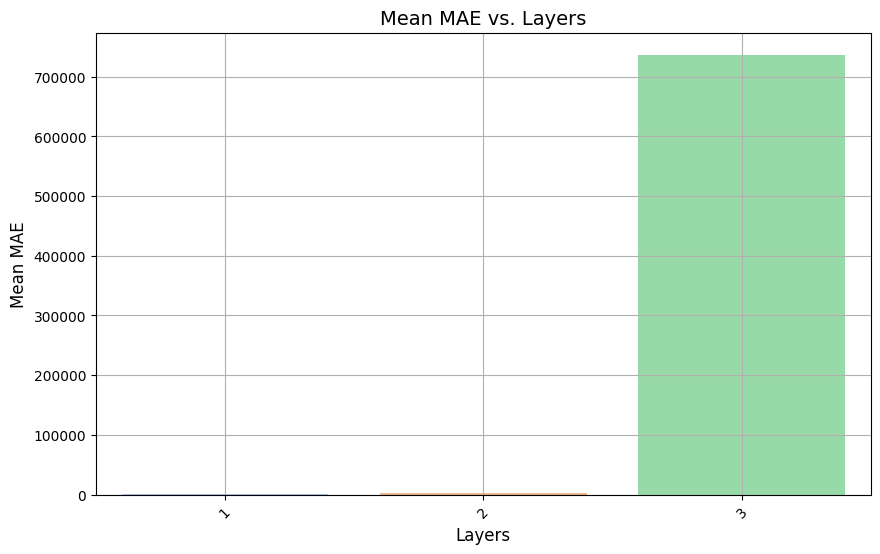

<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


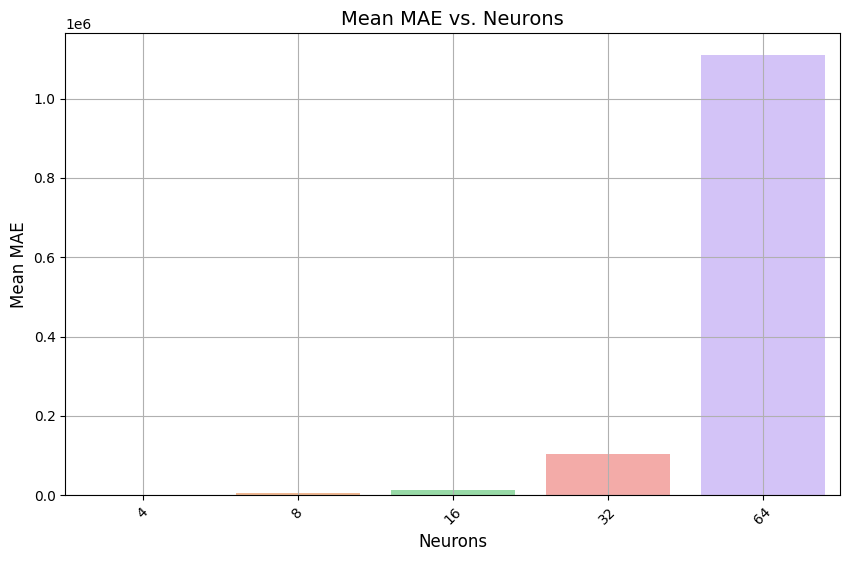

<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


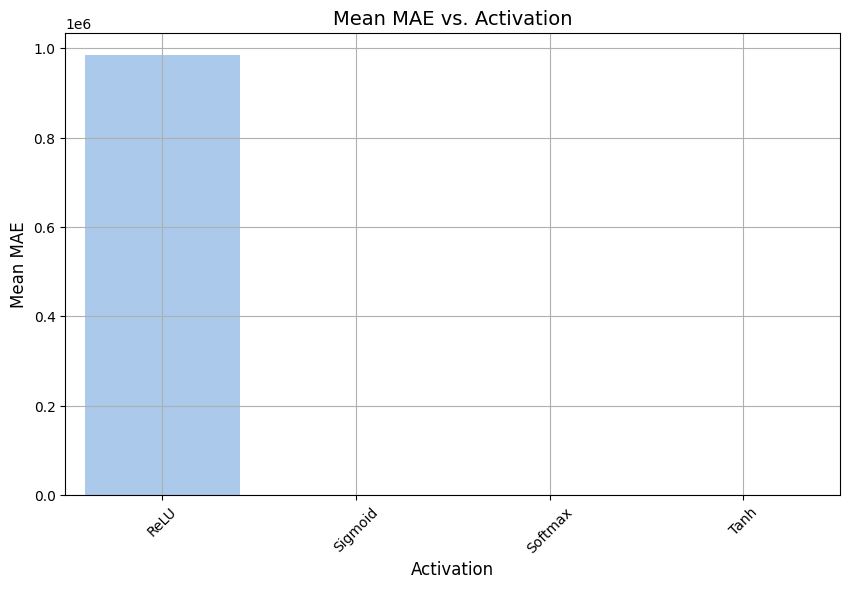

<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


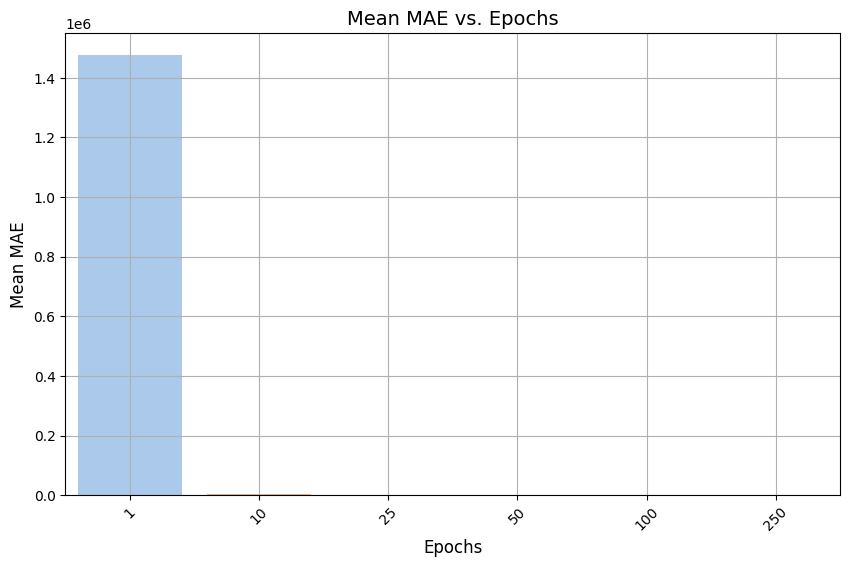

<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


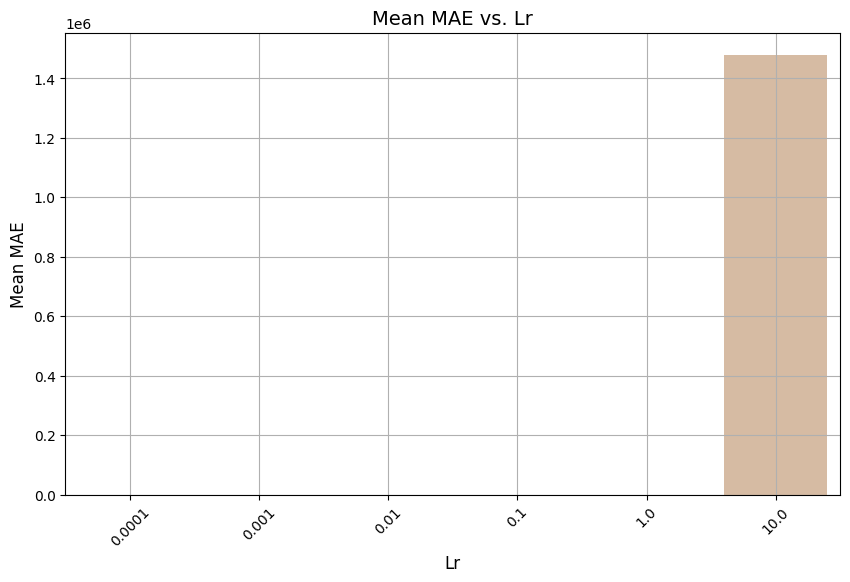

<ipython-input-19-24e299652439>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
<ipython-input-19-24e299652439>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")


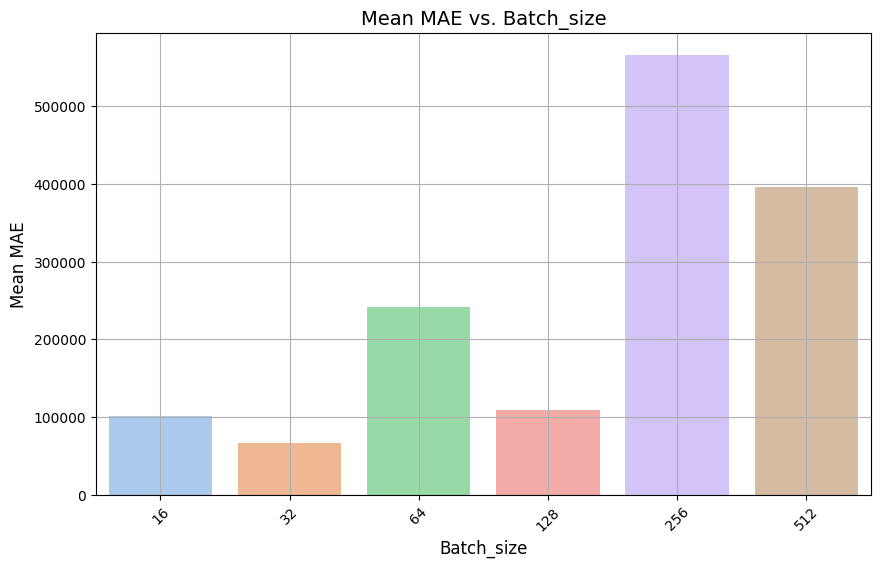

In [19]:
# Select relevant hyperparameters and mean MAE
hyperparameters = ['layers', 'neurons', 'activation', 'epochs', 'lr', 'batch_size']
mean_mae_by_hyperparameter = results_df.groupby(hyperparameters)['mae'].mean().reset_index()

# Plot mean MAE against each hyperparameter
for param in hyperparameters:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mean_mae_by_hyperparameter, x=param, y='mae', ci=None, palette="pastel")
    plt.title(f'Mean MAE vs. {param.capitalize()}', fontsize=14)
    plt.xlabel(param.capitalize(), fontsize=12)
    plt.ylabel('Mean MAE', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()